## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [4]:
# (re-)load layers
%run modules.py

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

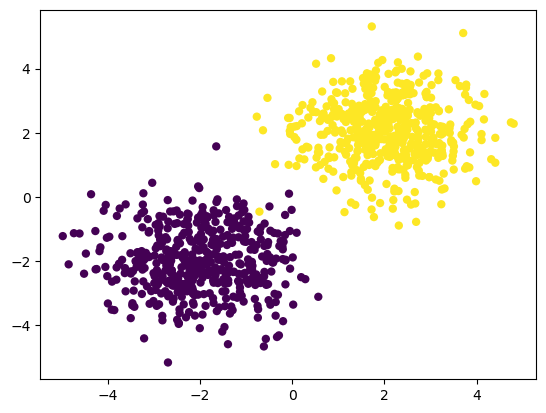

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [6]:
%run modules.ipynb

criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
# net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

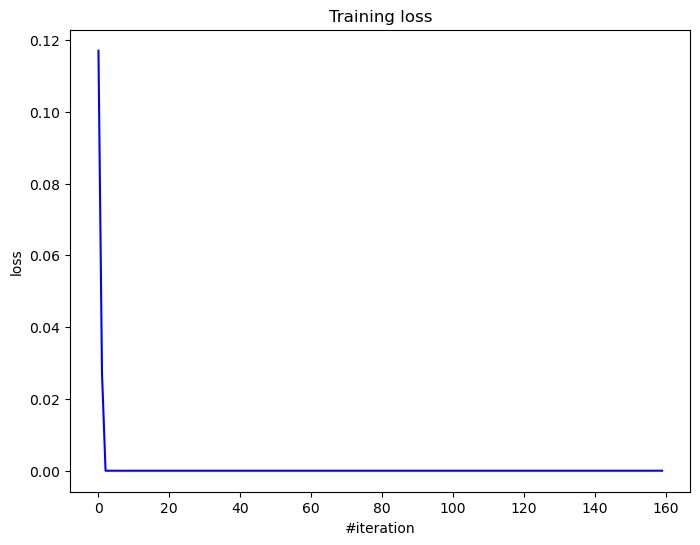

Current loss: 0.000000


In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [10]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [13]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [11]:
%run modules.py

In [21]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [13]:
# X_train, y_train = X_train[:5000], y_train[:5000]

In [30]:
def trainer(model, X_train, y_train, batch_size, optimizer, optimizer_config, optimizer_state, loss_history):
    model.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        model.zeroGradParameters()
        x_batch = x_batch.reshape(batch_size, np.prod(x_batch.shape[1:]))
        temp = []
        for idx in range(len(y_batch)):
            temp.append([1 if y_batch[idx] == i else 0 for i in range(10)])
        y_batch = np.array(temp)
        
        # Forward
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)
        
        # Update weights
        optimizer(model.getParameters(), 
                  model.getGradParameters(), 
                  optimizer_config,
                  optimizer_state)      
        
        loss_history.append(loss)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [180]:
def create_NN_model():
    model = Sequential()
    model.add(Linear(784, 138))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    model.add(ReLU())
    model.add(Linear(138, 128))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    model.add(ELU())
    model.add(Linear(128, 10))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

#### GDM optimizer

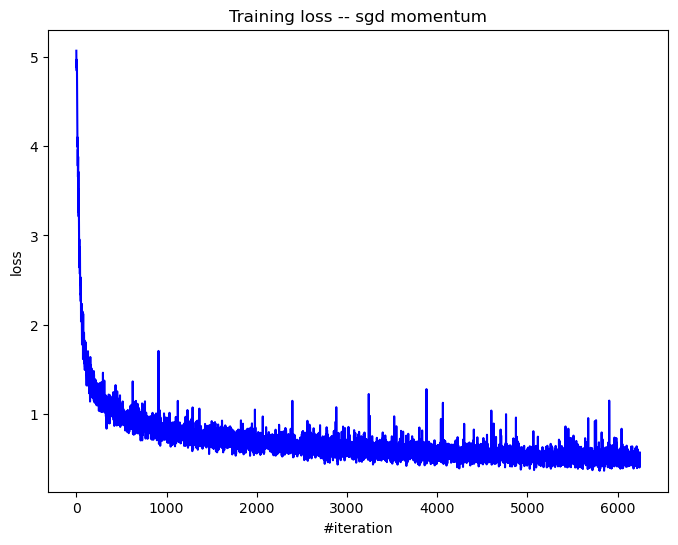

Current loss: 0.519150


In [181]:
criterion = MSECriterion()
MyStupidNN = create_NN_model()

# Looping params
n_epoch = 25
batch_size = 200
sgd_loss_history = []

# Optimizer params
sgd_optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.7}
sgd_optimizer_state = {}

MyStupidNN.train()

for i in range(n_epoch):
    trainer(MyStupidNN, X_train, y_train, batch_size, sgd_momentum, sgd_optimizer_config, sgd_optimizer_state, sgd_loss_history)    

    # Visualize
    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss -- sgd momentum")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(sgd_loss_history, 'b')
    plt.show()

    print('Current loss: %f' % sgd_loss_history[-1])

#### Adam optimizer

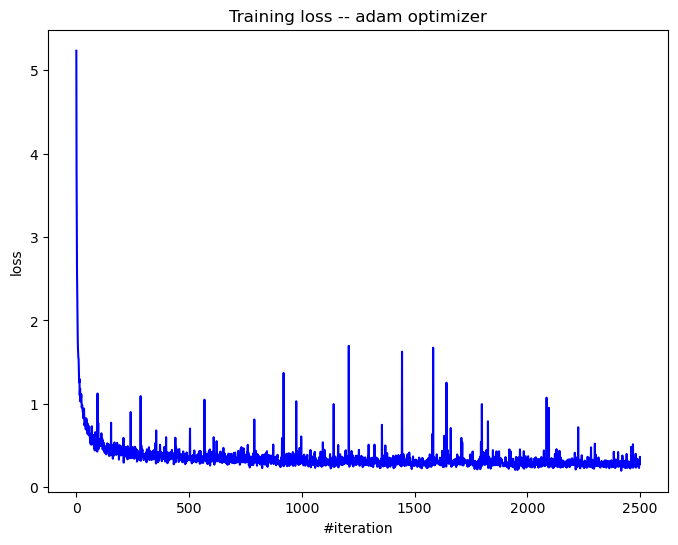

Current loss: 0.363705


In [188]:

adam_criterion = ClassNLLCriterionUnstable()
MyStupidNN_Adam = create_NN_model()

adam_loss_history = []
# Looping params
n_epoch = 10
batch_size = 200

# Optimizer params
adam_optimizer_config = {'learning_rate': 1e-2, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 1e-10}
adam_optimizer_state = {}

MyStupidNN.train()
for i in range(n_epoch):
    trainer(MyStupidNN_Adam, X_train, y_train, batch_size, adam_optimizer, adam_optimizer_config, adam_optimizer_state, adam_loss_history)

    # Visualize
    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss -- adam optimizer")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(adam_loss_history, 'b')
    plt.show()

    print('Current loss: %f' % adam_loss_history[-1])

In [68]:
test_count = len(y_test)
X_test, y_test = X_test.reshape(test_count, 28*28), y_test.reshape(test_count, 1)

Print here your accuracy on test set. It should be around 90%.

In [184]:
MyStupidNN.evaluate()
gdm_prediction = MyStupidNN.forward(X_test).argmax(axis=1, keepdims=True)
print("Accuracy of NN with gdm optimizer", np.sum(gdm_prediction == y_test)/test_count)

Accuracy of NN with gdm optimizer 0.8984


In [189]:
MyStupidNN_Adam.evaluate()
adam_predictions = MyStupidNN_Adam.forward(X_test).argmax(axis=1, keepdims=True)
print("Accuracy of NN with adam optimizer", np.sum(adam_predictions == y_test)/test_count)

Accuracy of NN with adam optimizer 0.9048


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Some activation functions, like ReLU, are computationally efficient and can significantly speed up the training process compared to others. However, it's essential to consider the trade-off between computation times and the expressiveness of the activation function.

BatchNormalization can indeed help in training deep neural networks. It normalizes the input of each layer, reducing the internal covariate shift and allowing for higher learning rates and faster convergence. This can lead to faster training times and better generalization on the test data. In addition, BatchNormalization can help to mitigate the vanishing and exploding gradients problem. However, it's important to note that while BatchNormalization can improve the performance and computation times of a neural network, it also adds some overhead to the training process.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [81]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [82]:
class NotSoStupidNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 138),
            nn.BatchNorm1d(138),
            nn.Dropout(0.35),
            nn.ReLU(),
            nn.Linear(138, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.35),
            nn.ELU(),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [83]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [84]:
model = NotSoStupidNN().to(device) # your code here
print(model)

NotSoStupidNN(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=138, bias=True)
    (2): BatchNorm1d(138, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.35, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=138, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)


In [85]:
learning_rate = 1e-3
batch_size = 200
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    data, labels = dataloader
    size = len(labels)

    model.train()
    for batch, (X, y) in enumerate(get_batches(dataloader, batch_size)):
        # Compute prediction and loss
        X = torch.tensor(X).cuda()
        y = torch.tensor(y).cuda()

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    clear_output(wait=True)


def test_loop(dataloader, model, loss_fn):
    data, labels = dataloader
    size = len(labels)

    model.eval()
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in get_batches(dataloader, batch_size):
            X = torch.tensor(X).cuda()
            y = torch.tensor(y).cuda()
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    clear_output(wait=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 60
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop((X_train, y_train), model, loss_fn, optimizer)
    test_loop((X_test, y_test), model, loss_fn)
print("Done!")

Test Error: 
 Accuracy: 97.9%, Avg loss: 1.932987 

Done!
